  ======================================================================================
  ## Travel Insurance     whether person will claim or not.
  ======================================================================================

## Loading modules

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
# the model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# for combining the preprocess with model training
from sklearn.pipeline import Pipeline
# for optimizing parameters of the pipeline
from sklearn.metrics import precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
import warnings
warnings.filterwarnings("ignore")

## Loading the data

In [55]:
train_dataset=pd.read_csv("D:/Grayatom/input/train.csv")
test_dataset=pd.read_csv("D:/Grayatom/input/test.csv")
submission_format = pd.read_csv("D:/Grayatom/input/sample_submission.csv")


## Making custom function

In [56]:
# customize print function to format the text
def printColorText(text,value=''):
    print("\33[01m {}\033[00m" .format(text),value,'\n')

# check statistics on given dataset
def displayDataSetInfo(data_set,name=''):
    printColorText('Shape of {} data -'.format(name),data_set.shape)
    printColorText('Display top 5 rows of {} data - \n'.format(name),data_set.head(5))
    printColorText('\n Display summary of statistics for {} data - \n\n'.format(name),data_set.describe())
    printColorText('\n Quick overview of {} data - '.format(name))
    print(data_set.info())
    printColorText('\n Detect % of missing values in the given {} dataset - \n\n'.format(name),round(data_set.isnull().sum()/data_set.shape[0],2))

# single variable distribution with Target variable
def univariate_dist(df,columns,coltype):
    fig, ax = plt.subplots(len(columns), figsize=(16,12))
    for i, col_val in enumerate(columns):
        if(coltype==0):
            sns.distplot(df[col_val], hist=True, ax=ax[i])
        else:
            sns.hist(df[col_val], hist=True, ax=ax[i])
            
        ax[i].set_title('Freq dist '+col_val, fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)
        ax[i].set_ylabel('Count', fontsize=8)
    plt.show()

# covariance - random two variable relationship -postive (move in same direction)/negative (move in opposite direction)    
def calculate_covariance(df,cols):
    df=df[cols]
    col1=cols[0]
    col2=cols[1]
    mean_col1,mean_col2=df[col1].mean(),df[col2].mean()
    diff_col1=df[col1]-mean_col1
    diff_col2=df[col2]-mean_col2
    covariance=sum(diff_col1*diff_col2)/len(diff_col1)
    return covariance

# outlier calculation based on threshold
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)
# plotting a outlier values -dots
def outlier_detection(data,cols):
    fig, ax = plt.subplots(len(cols), figsize=(10,5))
    for i, col_val in enumerate(cols):
        x = train_dataset[col_val][:1000]
        sns.distplot(x, ax=ax[i], rug=True, hist=False)
        outliers = x[percentile_based_outlier(x)]
        ax[i].plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

        ax[i].set_title('Outlier detection - {}'.format(col_val), fontsize=10)
        ax[i].set_xlabel(col_val, fontsize=8)

    plt.show()
# Calculate IQR
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    return Q3 - Q1,Q3,Q1

# create random train/test split
def split_train_valid_dataset(data,test_ratio):
    indices = range(data.shape[0])
    num_training_instances = int(test_ratio * data.shape[0])
    shuffled_indcies=np.random.randn(len(data))
    test_set_size= int(len(data)*test_ratio)
    train_indices = shuffled_indcies[:test_set_size]
    test_indices = shuffled_indcies[test_set_size:]
    #train_indices
    # split the actual data
    X_data_train, X_data_test = data.iloc[train_indices], data.iloc[test_indices]
    return X_data_train,X_data_test

# cross validate pipeline with multiclassfier 
def cross_validate_with_multiclassifier(clfs,pipe,X_train, y_train):
    for clf in clfs:
        pipe.set_params(classifier = clf)
        scores = cross_validate(pipe, X_train, y_train)
        print('===================================')
        classifier=clf
        print(str(classifier))
        print('===================================')
        for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())


## Take a look on Train dataset

In [57]:
displayDataSetInfo(train_dataset,'train')
#Keep formatted Column name for access purpose
train_dataset.columns=train_dataset.columns.str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
#remove unnecessary Id column
train_dataset.drop('id',axis=1,inplace=True)

 Shape of train data - (52310, 11) 

 Display top 5 rows of train data - 
      ID Agency    Agency Type Distribution Channel  \
0  2010    EPX  Travel Agency               Online   
1  4245    EPX  Travel Agency               Online   
2  9251    CWT  Travel Agency               Online   
3  4754    EPX  Travel Agency               Online   
4  8840    EPX  Travel Agency               Online   

                      Product Name  Duration  Destination  Net Sales  \
0                Cancellation Plan        61  PHILIPPINES       12.0   
1                Cancellation Plan         4     MALAYSIA       17.0   
2  Rental Vehicle Excess Insurance        26     THAILAND       19.8   
3         2 way Comprehensive Plan        15    HONG KONG       27.0   
4         2 way Comprehensive Plan        15     MALAYSIA       37.0   

   Commision (in value)  Age  Claim  
0                  0.00   41      0  
1                  0.00   35      0  
2                 11.88   47      0  
3              

## Take a look on Test Dataset

In [617]:
displayDataSetInfo(test_dataset,'test')
#Keep formatted Column name for access purpose
test_dataset.columns=test_dataset.columns.str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
test_dataset.columns
test_dataset_wo=test_dataset

 Shape of test data - (22421, 10) 

 Display top 5 rows of test data - 
       id agency    agency_type distribution_channel              product_name  \
0  17631    EPX  Travel Agency               Online         Cancellation Plan   
1  15064    EPX  Travel Agency               Online  1 way Comprehensive Plan   
2  14139    C2B       Airlines               Online               Bronze Plan   
3  19754    EPX  Travel Agency               Online  2 way Comprehensive Plan   
4  16439    C2B       Airlines               Online               Silver Plan   

   duration                destination  net_sales  commision_in_value  age  
0       192                  HONG KONG       18.0                0.00   36  
1         2                  SINGAPORE       20.0                0.00   36  
2        13                  SINGAPORE       13.5                3.38   24  
3       133  TAIWAN, PROVINCE OF CHINA       41.0                0.00   36  
4         2                  SINGAPORE       30.0      

## Filter categorical and numerical features

In [59]:
cat_traincols=train_dataset.select_dtypes(include='object')
num_traincols=train_dataset.select_dtypes(exclude='object')
cat_traincols.columns,num_traincols.columns

(Index(['agency', 'agency_type', 'distribution_channel', 'product_name',
        'destination'],
       dtype='object'),
 Index(['duration', 'net_sales', 'commision_in_value', 'age', 'claim'], dtype='object'))

## Exploratory Data Analysis

### Single variable distribution

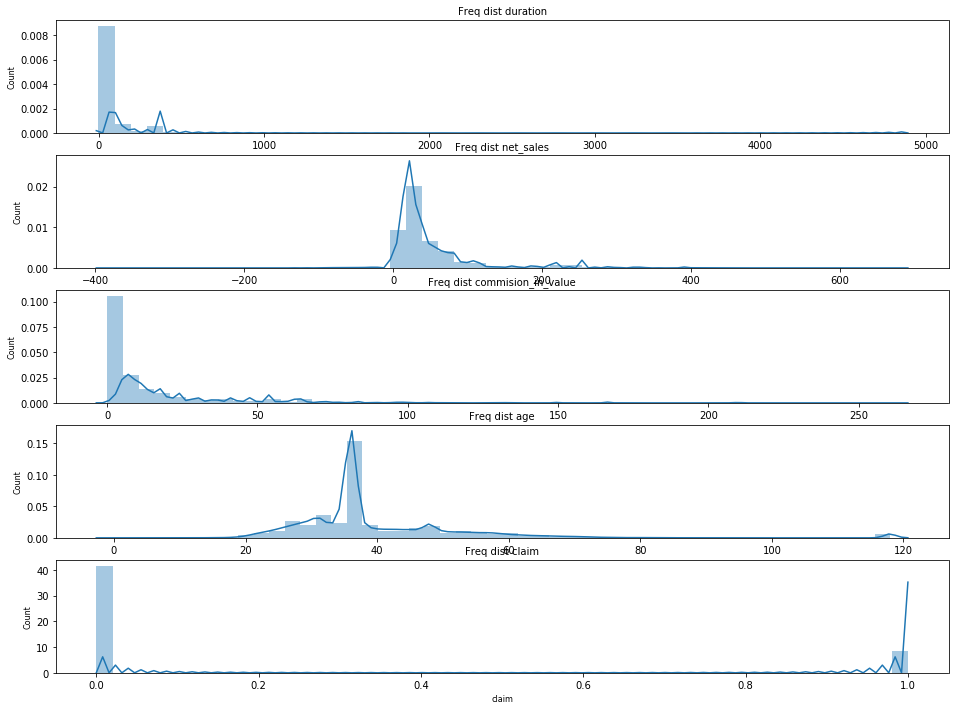

Text(0, 0.5, 'Count')

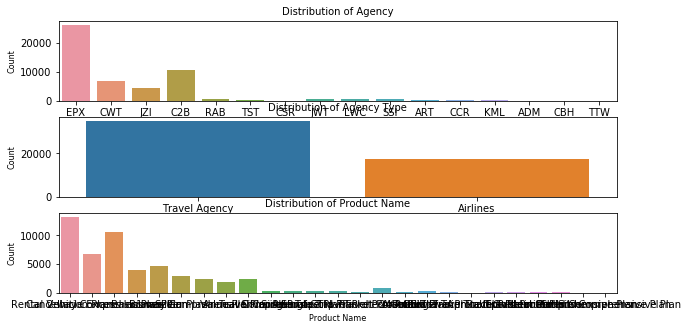

In [60]:
# # Univariate analysis for nuumerical cols -0, categorical cols - 1
num_col_name=num_traincols.columns
univariate_dist(train_dataset,num_col_name,0)

fig,axes=plt.subplots(nrows=3,figsize=(10,5))
sns.countplot(train_dataset['agency'],ax=axes[0])
axes[0].set_title('Distribution of Agency', fontsize=10)
axes[0].set_xlabel('Agency', fontsize=8)
axes[0].set_ylabel('Count', fontsize=8)
sns.countplot(train_dataset['agency_type'],ax=axes[1])
axes[1].set_title('Distribution of Agency Type', fontsize=10)
axes[1].set_xlabel('Agency Type', fontsize=8)
axes[1].set_ylabel('Count', fontsize=8)
sns.countplot(train_dataset['product_name'],ax=axes[2])
axes[2].set_title('Distribution of Product Name', fontsize=10)
axes[2].set_xlabel('Product Name', fontsize=8)
axes[2].set_ylabel('Count', fontsize=8)

#train_dataset.agency.value_counts().plot(kind='bar',ax=axes[3])


In [61]:
# # Check Skewness of data - postive (Right-skew) or negative (Left - skew) distribution
# # Here, Mean is higher than median (50 % data) then it's positive skew
# # so that it tells us that data point
print('Agency Descriptive Statistics \n')
print(train_dataset.agency.value_counts().describe())
print('\n Agency Type Descriptive Statistics')
print(train_dataset.agency_type.value_counts().describe())
print('\n Product Name Descriptive Statistics')
print(train_dataset.product_name.value_counts().describe())
print('\n Distribution Channel Descriptive Statistics')
print(train_dataset.distribution_channel.value_counts().describe())
print('\n Destination Descriptive Statistics')
print(train_dataset.destination.value_counts().describe())

Agency Descriptive Statistics 

count       16.000000
mean      3269.375000
std       6826.330082
min         56.000000
25%        143.000000
50%        460.500000
75%       1759.250000
max      26218.000000
Name: agency, dtype: float64

 Agency Type Descriptive Statistics
count        2.000000
mean     26155.000000
std      12503.062105
min      17314.000000
25%      21734.500000
50%      26155.000000
75%      30575.500000
max      34996.000000
Name: agency_type, dtype: float64

 Product Name Descriptive Statistics
count       25.000000
mean      2092.400000
std       3459.880646
min          8.000000
25%        130.000000
50%        295.000000
75%       2409.000000
max      13254.000000
Name: product_name, dtype: float64

 Distribution Channel Descriptive Statistics
count        2.00000
mean     26155.00000
std      35728.69144
min        891.00000
25%      13523.00000
50%      26155.00000
75%      38787.00000
max      51419.00000
Name: distribution_channel, dtype: float64

 Destinat

### Bivariate distribution

In [62]:
## Covariance - how two variable are related, postive or negative
print('Age vs NetSales -' ,calculate_covariance(train_dataset,['age','net_sales']))
print('Age vs duration -' ,calculate_covariance(train_dataset,['age','duration']))
print('Age vs Commision Value -' ,calculate_covariance(train_dataset,['age','commision_in_value']))
print('Age vs Claim -' ,calculate_covariance(train_dataset,['age','claim']))

## Covariance - how two variable are related, postive or negative
print('Duration vs NetSales -' ,calculate_covariance(train_dataset,['duration','net_sales']))
print('Duration vs age -' ,calculate_covariance(train_dataset,['duration','age']))
print('Duration vs Commision Value -' ,calculate_covariance(train_dataset,['duration','commision_in_value']))
print('Duration vs Claim -' ,calculate_covariance(train_dataset,['duration','claim']))
## Covariance - how two variable are related, postive or negative
print('Commision Value vs NetSales -' ,calculate_covariance(train_dataset,['commision_in_value','net_sales']))
print('Commision Value vs age -' ,calculate_covariance(train_dataset,['commision_in_value','age']))
print('Commision Value vs Duration -' ,calculate_covariance(train_dataset,['commision_in_value','duration']))
print('Commision Value vs Claim -' ,calculate_covariance(train_dataset,['commision_in_value','claim']))

Age vs NetSales - 18.728605645417215
Age vs duration - -5.961882131364287
Age vs Commision Value - 27.4987440113418
Age vs Claim - -0.3089261366687204
Duration vs NetSales - 3910.791012143564
Duration vs age - -5.961882131364287
Duration vs Commision Value - 1204.7366751146612
Duration vs Claim - 8.199670040533155
Commision Value vs NetSales - 1008.2977757486259
Commision Value vs age - 27.4987440113418
Commision Value vs Duration - 1204.7366751146612
Commision Value vs Claim - 2.202829463003784


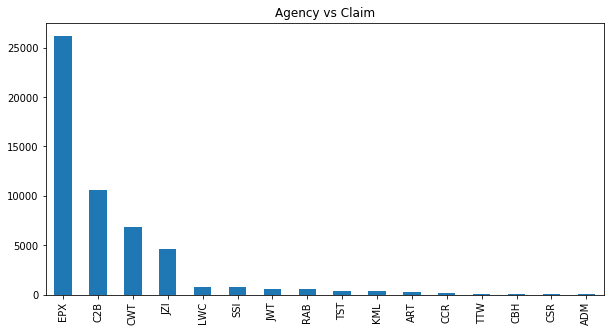

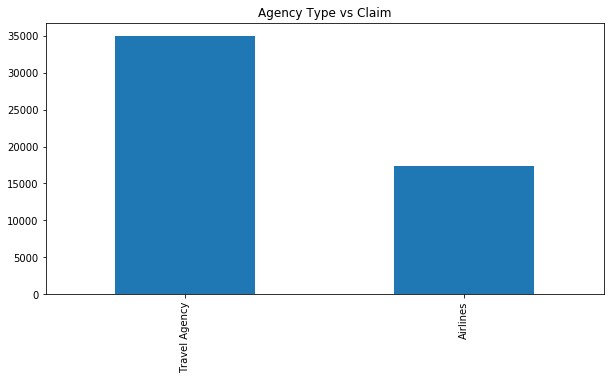

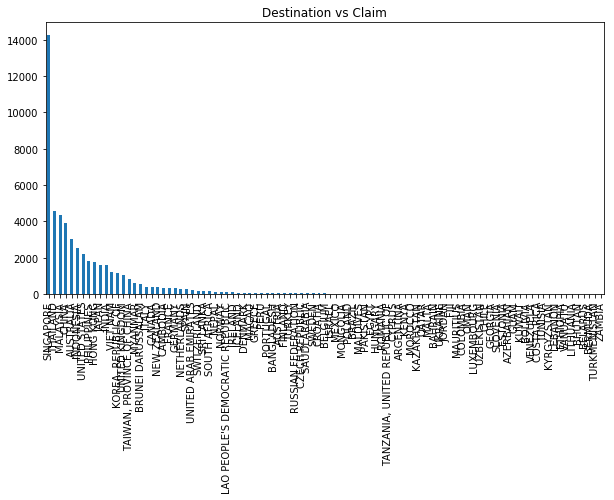

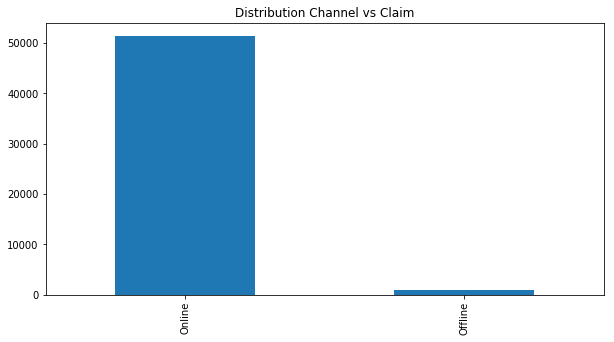

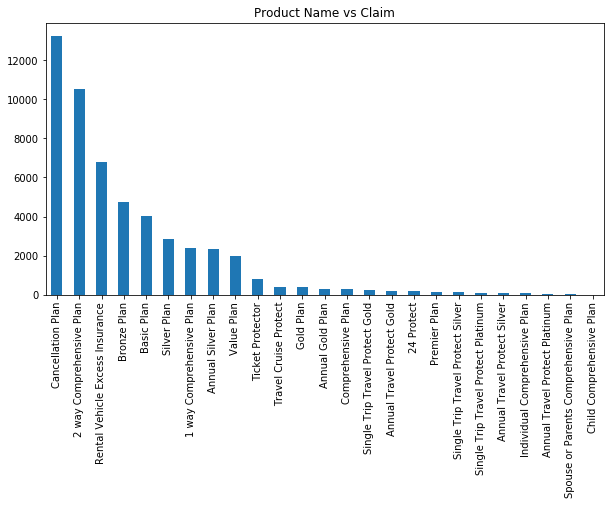

In [63]:
# # byvariate variable analysis
fig,axes=plt.subplots(figsize=(10,5))
train_dataset.agency.value_counts().plot(kind='bar',title='Agency vs Claim')
fig,axes=plt.subplots(figsize=(10,5))
train_dataset.agency_type.value_counts().plot(kind='bar',title='Agency Type vs Claim')
fig,axes=plt.subplots(figsize=(10,5))
train_dataset.destination.value_counts().plot(kind='bar',title='Destination vs Claim')
fig,axes=plt.subplots(figsize=(10,5))
train_dataset.distribution_channel.value_counts().plot(kind='bar',title='Distribution Channel vs Claim')
fig,axes=plt.subplots(figsize=(10,5))
train_dataset.product_name.value_counts().plot(kind='bar',title='Product Name vs Claim')

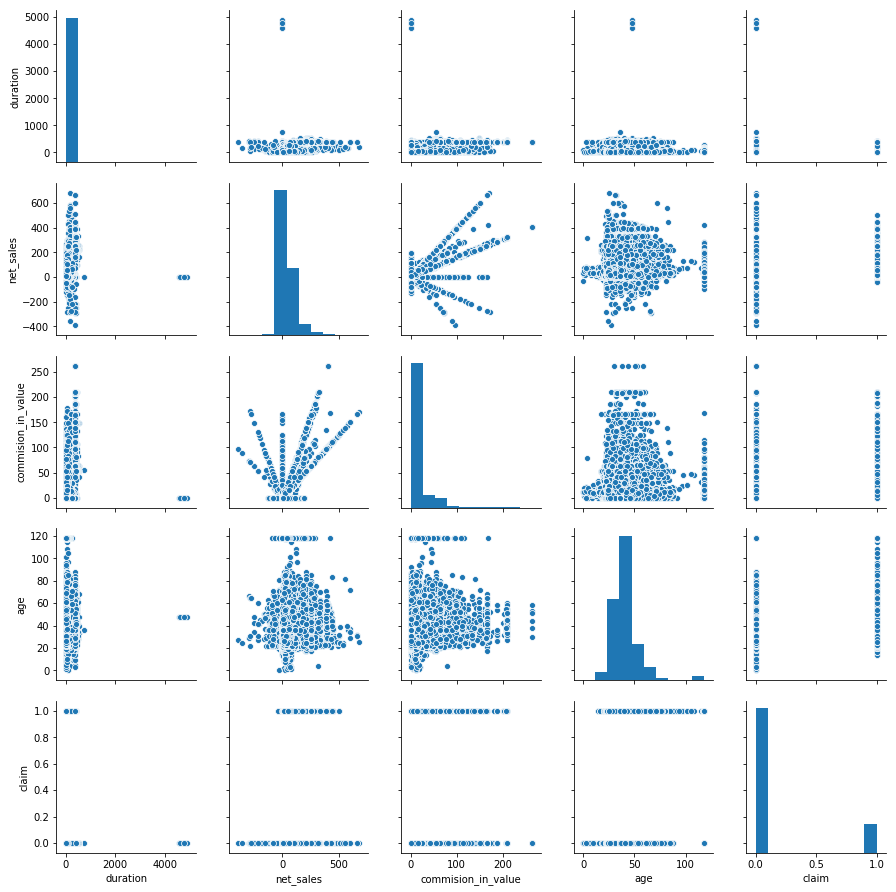

In [64]:
sns.pairplot(train_dataset)

## Outliers Detection

Text(0.5, 1.0, 'Duration')

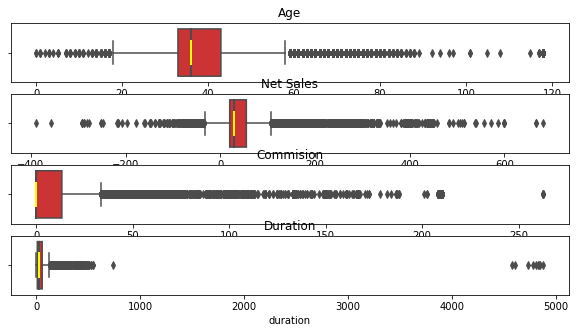

In [65]:
#Draw a box plot to see data distribution using boxplot 
# 
fig,axes=plt.subplots(nrows=4,figsize=(10,5))
sns.boxplot(x='age',data=train_dataset,ax=axes[0],palette="Set1",notch = True,
            medianprops = dict(linestyle='-', linewidth=2, color='Yellow'))
axes[0].set_title('Age')
sns.boxplot(x='net_sales',data=train_dataset,ax=axes[1],palette="Set1",notch = True,
            medianprops = dict(linestyle='-', linewidth=2, color='Yellow'))
axes[1].set_title('Net Sales')
sns.boxplot(x='commision_in_value',data=train_dataset,ax=axes[2],palette="Set1",notch = True,
            medianprops = dict(linestyle='-', linewidth=2, color='Yellow'))
axes[2].set_title('Commision')
sns.boxplot(x='duration',data=train_dataset,ax=axes[3],palette="Set1",notch = True,
            medianprops = dict(linestyle='-', linewidth=2, color='Yellow'))
axes[3].set_title('Duration')


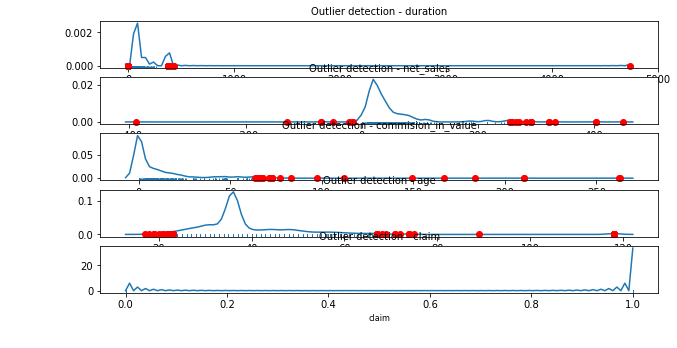

In [66]:
outlier_detection(train_dataset,num_col_name)

### Calculate IQR 

In [67]:
#Calculate Statistics - IQR using formulae
IQR_train,Q3,Q1 = IQR(train_dataset)
IQR_test,Q3_t,Q1_t =IQR(test_dataset)
print("interquartile range for train data set - \n",IQR_train)
print("\n interquartile range for test data set - \n",IQR_test)

interquartile range for train data set - 
 duration              47.00
net_sales             35.20
commision_in_value    13.38
age                   10.00
claim                  0.00
dtype: float64

 interquartile range for test data set - 
 id                    4526.00
duration                48.00
net_sales               36.20
commision_in_value      13.63
age                      9.00
dtype: float64


Before removal - shape of train data - (52310, 10)
After removal - shape of train data - (41633, 10)


Text(0.5, 1.0, 'Duration')

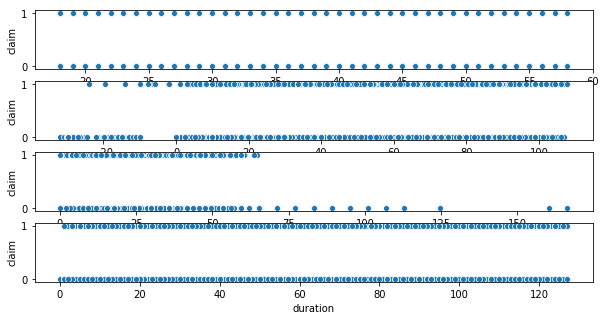

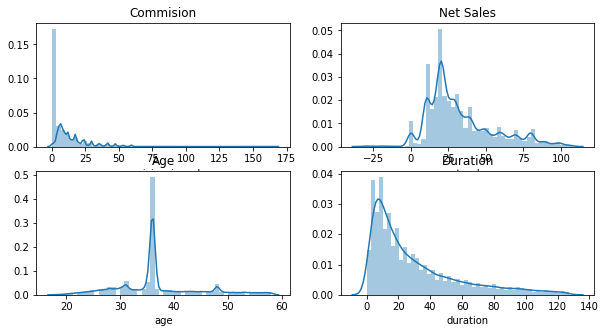

In [68]:
# Detect outliers
#print(train_dataset > (Q3 + 1.5* IQR)) or (train_dataset < (Q1 - 1.5*IQR))
print("Before removal - shape of train data -",train_dataset.shape)
# Removing outliers -wo without outlier
train_dataset_wo = train_dataset[~((train_dataset[['age','commision_in_value','net_sales','duration']] < (Q1 - 1.5 * IQR_train)) |(train_dataset[['age','net_sales','duration']] > (Q3 + 1.5 * IQR_train))).any(axis=1)]
test_dataset_wo = test_dataset[~((test_dataset[['age','commision_in_value','net_sales','duration']] < (Q1_t - 1.5 * IQR_test)) |(test_dataset[['age','net_sales','duration']] > (Q3_t + 1.5 * IQR_test))).any(axis=1)]
# check how many rows are removed
print("After removal - shape of train data -",train_dataset_wo.shape)

# Draw scatter plot to see behaviour of each column with target Claim after remove outliers
fig,axes=plt.subplots(nrows=4,figsize=(10,5))
sns.scatterplot(train_dataset_wo.age,train_dataset_wo.claim,ax=axes[0])
sns.scatterplot(train_dataset_wo.net_sales,train_dataset_wo.claim,ax=axes[1])
sns.scatterplot(train_dataset_wo.commision_in_value,train_dataset_wo.claim,ax=axes[2])
sns.scatterplot(train_dataset_wo.duration,train_dataset_wo.claim,ax=axes[3])

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,5))
sns.distplot(train_dataset_wo['commision_in_value'],ax=axes[0][0])
axes[0][0].set_title('Commision')
sns.distplot(train_dataset_wo['net_sales'],ax=axes[0][1])
axes[0][1].set_title('Net Sales')
sns.distplot(train_dataset_wo['age'],ax=axes[1][0])
axes[1][0].set_title('Age')
sns.distplot(train_dataset_wo['duration'],ax=axes[1][1])
axes[1][1].set_title('Duration')

### LabelEncoding and Heatmap to see highly correlated columns


 no feature looks like highly correlated with others


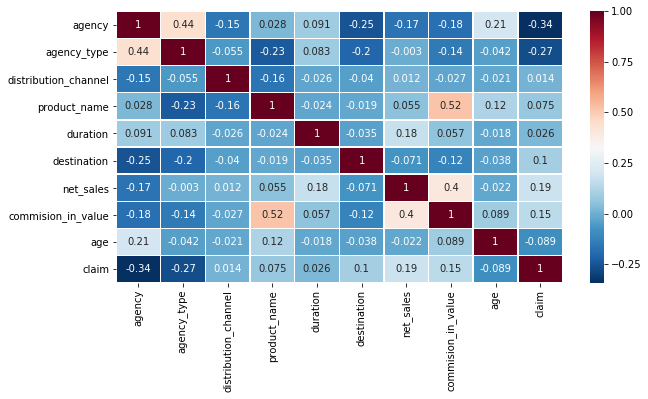

In [619]:
# creating a label encoder
le = LabelEncoder()
# label encoding for categorical columns
train_dataset_wo['agency'] = le.fit_transform(train_dataset_wo.iloc[:,:-1]['agency'])
test_dataset_wo['agency'] = le.fit_transform(test_dataset_wo['agency'])
# label encoding for agency_type
train_dataset_wo['agency_type'] = le.fit_transform(train_dataset_wo.iloc[:,:-1]['agency_type'])
test_dataset_wo['agency_type'] = le.fit_transform(test_dataset_wo['agency_type'])
# label encoding for destination
train_dataset_wo['destination'] = le.fit_transform(train_dataset_wo.iloc[:,:-1]['destination'])
test_dataset_wo['destination'] = le.fit_transform(test_dataset_wo['destination'])
# label encoding for productname
train_dataset_wo['product_name'] = le.fit_transform(train_dataset_wo.iloc[:,:-1]['product_name'])
test_dataset_wo['product_name'] = le.fit_transform(test_dataset_wo['product_name'])
# label encoding for distribution channel
train_dataset_wo['distribution_channel'] = le.fit_transform(train_dataset_wo.iloc[:,:-1]['distribution_channel'])
test_dataset_wo['distribution_channel'] = le.fit_transform(test_dataset_wo['distribution_channel'])
corr_matrix_num=train_dataset_wo.corr(method='pearson')
fig,axes=plt.subplots(nrows=1,figsize=(10,5))
sns.heatmap(corr_matrix_num,xticklabels=corr_matrix_num.columns,yticklabels=corr_matrix_num.columns,cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
print('\n no feature looks like highly correlated with others')


In [345]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=True,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l2',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
                                 threshold=None)),
                ('classification',
                 RandomF...rue, ccp_alpha=0.0,
      

In [392]:
X=train_dataset_wo.iloc[:,:-1]
y=train_dataset_wo.iloc[:,-1]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)
y_train.value_counts(),y_test.value_counts(),y.value_counts()

(0    25059
 1     4084
 Name: claim, dtype: int64, 0    10739
 1     1751
 Name: claim, dtype: int64, 0    35798
 1     5835
 Name: claim, dtype: int64)

In [609]:
contingency_table=pd.crosstab(train_dataset_wo['distribution_channel'],train_dataset_wo["claim"])
#print('contingency_table :-\n',contingency_table)

#Observed Values
Observed_Values = contingency_table.values 
#print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
#print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
df11=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",df11)
alpha=0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=df11)
print('critical_value:',critical_value)
p_value=1-chi2.cdf(x=chi_square_statistic,df=df11)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',df11)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)
 
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

Degree of Freedom:- 1
chi-square statistic:- 7.642751339980923
critical_value: 3.841458820694124
p-value: 0.005700090805787927
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 7.642751339980923
critical_value: 3.841458820694124
p-value: 0.005700090805787927
Reject H0,There is a relationship between 2 categorical variables


### Feature Engineering

In [393]:
# # Use Data Sampling techniques
# # SMOTE vs Random oversampling
from sklearn.feature_selection import f_classif,chi2,SelectKBest

# # f_classif
skb = SelectPercentile(f_classif, percentile=95)
predictors=skb.fit_transform(X_train, y_train)
scores=skb.scores_.tolist() 
print(scores)
Features=X_train.columns
print(Features)
scaledfeatured_df=pd.DataFrame({'features':Features,'scores':scores})
scaledfeatured_df.sort_values(by='scores',ascending=None,inplace=True)
top_fclassif_predictors = list(scaledfeatured_df['features'][:predictors.shape[1]])
top_fclassif_predictors
# # Chi2
#X_train_log=np.log(X_train)
skb1 = SelectPercentile(chi2, percentile=95)
predictors=skb1.fit_transform(X_train[cat_traincols.columns], y_train)
scores=skb1.scores_.tolist() 
print(scores)
Features=cat_traincols.columns
print(Features)
scaledfeatured_df=pd.DataFrame({'features':Features,'scores':scores})
scaledfeatured_df.sort_values(by='scores',ascending=None,inplace=True)
top_k_predictors = list(scaledfeatured_df['features'][:predictors.shape[1]])
top_k_predictors

print(top_fclassif_predictors,top_k_predictors)
#X_train,X_test,y_train,y_test=train_test_split(X[top_k_predictors],y,test_size=0.3,random_state=0)
top_fclassif_predictors=['agency', 'agency_type', 'net_sales', 'commision_in_value', 'age', 'destination', 'duration']

[3973.1151356526507, 2291.285616901797, 2.612415711078234, 146.4305341183118, 26.192079334619617, 291.5946128186143, 1074.7401903744778, 665.5773391007887, 230.59181049107323]
Index(['agency', 'agency_type', 'distribution_channel', 'product_name',
       'duration', 'destination', 'net_sales', 'commision_in_value', 'age'],
      dtype='object')
[2711.4912678631035, 602.3390498296736, 0.020796339049296904, 413.9140218352742, 3848.794844151866]
Index(['agency', 'agency_type', 'distribution_channel', 'product_name',
       'destination'],
      dtype='object')
['agency', 'agency_type', 'net_sales', 'commision_in_value', 'destination', 'age', 'product_name', 'duration'] ['destination', 'agency', 'agency_type', 'product_name']


In [394]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
clf = LogisticRegression(random_state=0, multi_class='multinomial')
clf1 = LogisticRegression(random_state=0, multi_class='multinomial')
model_fit_all_features =clf1.fit(X_train,y_train)
predictions_all_features=model_fit_all_features.predict(X_test)
score_all_features=model_fit_all_features.score(X_test,y_test)
print(score_all_features)
top_k_predictors=['agency', 'agency_type', 'net_sales', 'commision_in_value', 'destination', 'age', 'product_name', 'duration']

model_fit_top_features=clf.fit(X_train[top_fclassif_predictors],y_train)
predictions_top_features=model_fit_top_features.predict(X_test[top_fclassif_predictors])
score_top_features=model_fit_top_features.score(X_test[top_fclassif_predictors],y_test)
print(score_top_features)
#print(cat_traincols.columns,num_traincols.columns)

0.8648518815052042
0.8646917534027222


### SET Transformers for a pipeline

In [39]:
pipe = Pipeline(steps=[('scale', StandardScaler()), 
                       ('classifier',(LogisticRegression()))])
pipe.steps

[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('classifier',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

## Prepare data before modeling

In [73]:
print(train_dataset_wo.claim.value_counts())
print("\n What is the percentage of claim before modeling -",train_dataset_wo.claim.value_counts()[1].sum()/train_dataset_wo.claim.value_counts().sum()*100)
print("\n What is the percentage of unclaim before modeling -",train_dataset_wo.claim.value_counts()[0].sum()/train_dataset_wo.claim.value_counts().sum()*100)
# Train model
clf_0 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_0 = clf_0.predict(X)

# How's the accuracy?
print( "\n Train the model and check accuracy of model -",accuracy_score(pred_y_0, y)*100 )
print("\n So our model has 86% overall accuracy but it is because it is predicting majority class '0'( No Claim)")

0    35798
1     5835
Name: claim, dtype: int64

 What is the percentage of claim before modeling - 14.015324382100738

 What is the percentage of unclaim before modeling - 85.98467561789927

 Train the model and check accuracy of model - 86.52751423149905

 So our model has 86% overall accuracy but it is because it is predicting majority class '0'( No Claim)


### Imbalanced Dataset

0    35798
1     5835
Name: claim, dtype: int64


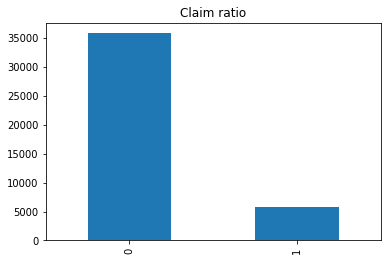

[0.58148769 3.56794809]


In [395]:
print(train_dataset_wo.claim.value_counts())
train_dataset_wo.claim.value_counts().plot(kind='bar',title='Claim ratio')
plt.show()

cls_weights = compute_class_weight('balanced',
                                                 np.unique(y_train.values),
                                                 y_train.values)
print(cls_weights)
## use of SMOTE OR RANDOM SAMPLING

## Try with Multiple Classifier

In [359]:
clfs=[LogisticRegression(),
         DecisionTreeClassifier(),
         SVC(),
         GradientBoostingClassifier(),
         RandomForestClassifier(),
         KNeighborsClassifier()]

cross_validate_with_multiclassifier(clfs,pipe,X_train[top_fclassif_predictors],y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
fit_time  mean  0.3818219184875488
fit_time  std  0.4843587635367376
score_time  mean  0.08940505981445312
score_time  std  0.163330616005987
test_score  mean  0.863260461472723
test_score  std  0.0018100142252055614
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
fit_time  mean  0.162209320068

In [399]:
## SMOTE vs Random Sampling
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
#!pip install scikit-learn==0.18.2 
#!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

# Before sampling 
print('\nDistribution of target variable before Random OverSampling:\n', train_dataset_wo.claim.value_counts())

ros = RandomOverSampler(random_state=42)

x_sample,y_sample =  ros.fit_sample(train_dataset_wo.iloc[:,:-1],train_dataset_wo['claim'])
#x_testsample,y_testsample =  ros.fit_sample(test_dataset_wo.iloc[:,:-1],test_dataset_wo['claim'])

#After Sampling    
print('\nDistribution of target variable after Random OverSampling:\n', y_sample.value_counts())
x_sample.shape,X_train.shape,y_sample.shape,y_train.shape

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

cls_weights = compute_class_weight('balanced',
                                                 np.unique(y_train.values),
                                                 y_train.values)
print(cls_weights)


Distribution of target variable before Random OverSampling:
 0    35798
1     5835
Name: claim, dtype: int64

Distribution of target variable after Random OverSampling:
 1    35798
0    35798
Name: claim, dtype: int64
[0.58148769 3.56794809]


In [611]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from collections import Counter
training_features=train_dataset_wo.iloc[:,:-1]
training_target=train_dataset_wo.iloc[:,-1]
x_train1, x_val, y_train1, y_val = train_test_split(training_features, training_target,
                                                  test_size = .1,
                                                  random_state=42)
sm = RandomOverSampler(random_state=42)
top_fclassif_predictors=['agency', 'agency_type', 'net_sales', 'commision_in_value', 'destination', 'age', 'product_name', 'duration']

x_train_res, y_train_res = sm.fit_sample(x_train1, y_train1)
#clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
#clf_rf.fit(x_train_res[top_fclassif_predictors], y_train_res)
#pipe.get_params().keys()
pipe.set_params(classifier=RandomForestClassifier())
#cv_grid = GridSearchCV(pipe, param_grid = {
#    'classifier__kernel' : [ 'rbf']
#})
parameter_grid = {"classifier__max_features": [1, 3, 10],
              "classifier__bootstrap": [True],
              "classifier__criterion": ["entropy"],
                 "classifier__random_state":[42]}
#cv_grid = GridSearchCV(pipe, param_grid =parameter_grid)
cv_grid = GridSearchCV(pipe, param_grid = {
        'classifier__criterion' : ['entropy'],
    #'classifier__class_weight':[{0:0.582,1:3.526}],
    'classifier__n_estimators' : [100]
    
})
#np.linspace(0.1,1.2,4)
#cv_grid.fit(x_train_res[top_fclassif_predictors], y_train_res)
cv_grid.fit(x_train_res, y_train_res)
#cv_grid.fit(x_sample[top_fclassif_predictors], y_sample)
print("best combination of the parameters -", cv_grid.best_params_)
print("best estimator -",cv_grid.best_estimator_)
print("best score -",cv_grid.best_score_)
#y_pred = cv_grid.predict(X_test[top_fclassif_predictors])
y_pred = cv_grid.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))


best combination of the parameters - {'classifier__criterion': 'entropy', 'classifier__n_estimators': 100}
best estimator - Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, ran

In [616]:
cID=test_dataset_wo['id']
# drop ID column from test dataset
testing_values=test_dataset_wo.drop(['id'],axis=1)
# predictiction on given test
#predict_test=cv_grid.predict(testing_values[top_fclassif_predictors])
predict_test=cv_grid.predict(testing_values)
predictions = pd.DataFrame({'ID':cID,'Claim':predict_test})

print(predictions.Claim.value_counts(),np.bincount(y_pred))
#predictions.to_csv("D:\Grayatom\input\submission.csv", index=False)
testing_values

0    15612
1     1836
Name: Claim, dtype: int64 [10683  1807]


,agency,agency_type,distribution_channel,product_name,duration,destination,net_sales,commision_in_value,age
1,7,1,1,0,2,73,20.000000,0.00,36
2,2,0,1,4,13,73,13.500000,3.38,24
4,2,0,1,10,2,73,30.000000,7.50,32
5,2,0,1,4,13,73,13.500000,3.38,41
6,7,1,1,1,120,93,23.000000,0.00,36
7,2,0,1,4,57,73,60.000000,15.00,33
9,7,1,1,5,18,40,56.000000,0.00,36
10,7,1,1,0,2,93,20.000000,0.00,36
12,7,1,1,5,34,35,10.000000,0.00,39
13,7,1,1,1,5,82,20.000000,0.00,39


In [613]:
print (cv_grid.score(x_val, y_val))
print (recall_score(y_val, cv_grid.predict(x_val)))
print (precision_score(y_val, cv_grid.predict(x_val)))
print("\n Classification report :\n")
print(classification_report(y_val, cv_grid.predict(x_val)))
print("\n Confusion Matrix :\n")
print(confusion_matrix(y_val, cv_grid.predict(x_val)))

print('\nTest Results')
print (cv_grid.score(testing_values,predictions.Claim))
print (recall_score(predictions.Claim,predict_test))
print (precision_score(predictions.Claim,predict_test))
print("\n Classification report :\n")
print(classification_report(predictions.Claim, predict_test))
print("\n Confusion Matrix :\n")
print(confusion_matrix(predictions.Claim, predict_test))


0.9474063400576369
0.8316326530612245
0.8029556650246306

 Classification report :

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3576
           1       0.80      0.83      0.82       588

    accuracy                           0.95      4164
   macro avg       0.89      0.90      0.89      4164
weighted avg       0.95      0.95      0.95      4164


 Confusion Matrix :

[[3456  120]
 [  99  489]]

Test Results
1.0
1.0
1.0

 Classification report :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15612
           1       1.00      1.00      1.00      1836

    accuracy                           1.00     17448
   macro avg       1.00      1.00      1.00     17448
weighted avg       1.00      1.00      1.00     17448


 Confusion Matrix :

[[15612     0]
 [    0  1836]]


In [486]:
print('Validation Results')
print (cv_grid.score(x_val[top_fclassif_predictors], y_val))
print (recall_score(y_val, cv_grid.predict(x_val[top_fclassif_predictors])))
print (precision_score(y_val, cv_grid.predict(x_val[top_fclassif_predictors])))
print("\n Classification report :\n")
print(classification_report(y_val, cv_grid.predict(x_val[top_fclassif_predictors])))
print("\n Confusion Matrix :\n")
print(confusion_matrix(y_val, cv_grid.predict(x_val[top_fclassif_predictors])))

print('\nTest Results')
print (cv_grid.score(test_dataset_wo[top_fclassif_predictors],predictions.Claim))
print (recall_score(predictions.Claim,predict_test))
print (precision_score(predictions.Claim,predict_test))
print("\n Classification report :\n")
print(classification_report(predictions.Claim, predict_test))
print("\n Confusion Matrix :\n")
print(confusion_matrix(predictions.Claim, predict_test))


Validation Results
0.9478866474543708
0.822992700729927
0.7898423817863398

 Classification report :

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3616
           1       0.79      0.82      0.81       548

    accuracy                           0.95      4164
   macro avg       0.88      0.89      0.89      4164
weighted avg       0.95      0.95      0.95      4164


 Confusion Matrix :

[[3496  120]
 [  97  451]]

Test Results
1.0
1.0
1.0

 Classification report :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15547
           1       1.00      1.00      1.00      1901

    accuracy                           1.00     17448
   macro avg       1.00      1.00      1.00     17448
weighted avg       1.00      1.00      1.00     17448


 Confusion Matrix :

[[15547     0]
 [    0  1901]]


## Find out best accuracy algorithm to fit the model 

In [500]:
results = model_selection.cross_val_score(pipe, X_train, y_train, cv=kfold)
print(results.mean())
print("================================================================")
results_samples = model_selection.cross_val_score(pipe, x_train_res, y_train_res, cv=kfold)
print(results_samples.mean())

0.9444119534135205
0.9810461664439376


## Evaluate Model

accuracy score : 0.9902321857485988
precision score : 0.9467910038398245
recall score : 0.9857224443175329

 Classification report :

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     10739
           1       0.95      0.99      0.97      1751

    accuracy                           0.99     12490
   macro avg       0.97      0.99      0.98     12490
weighted avg       0.99      0.99      0.99     12490


 Confusion Matrix :

[[10642    97]
 [   25  1726]]
10642 97 25 1726
MSE : 0.00976781425140112
RMSE : 0.09883225309280934
r2 score : 0.9189650664016024


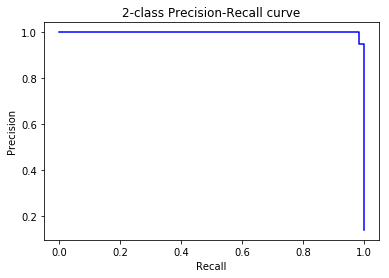

0    10739
1     1751
Name: claim, dtype: int64


In [478]:
# Calculating the metric score
from sklearn.metrics import precision_score,r2_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix
r2 = accuracy_score(y_test, y_pred)
print("accuracy score :", r2)
r2 = precision_score(y_test, y_pred)
print("precision score :", r2)
r2 = recall_score(y_test, y_pred)
print("recall score :", r2)
print("\n Classification report :\n")
print(classification_report(y_test, y_pred))
print("\n Confusion Matrix :\n")
print(confusion_matrix(y_test, y_pred))
tp, fn, fp, tn =confusion_matrix(y_test, y_pred).ravel()
print(tp, fn, fp, tn )
# calculating the mean squared error
mse = np.mean((y_test - y_pred)**2, axis = None)
print("MSE :", mse)

# Calculating the root mean squared error
rmse = np.sqrt(mse)
print("RMSE :", rmse)

# Calculating the r2 score
r2 = r2_score(y_test, y_pred)
print("r2 score :", r2)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

thresholds = np.append(thresholds, 1)
plt.step(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('2-class Precision-Recall curve')
plt.show()
print(y_test.value_counts())

0.017101759173462856
0    10739
1     1751
Name: claim, dtype: int64
0    10677
1     1813
dtype: int64


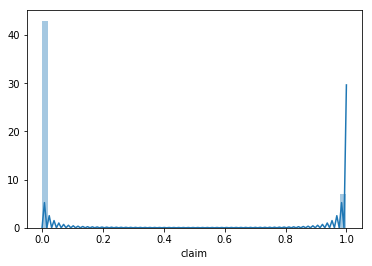

In [502]:
from sklearn.metrics import log_loss

in_sample_preds = cv_grid.predict_proba(x_train_res)
print(log_loss(y_train_res, in_sample_preds))
print(y_test.value_counts())#,y_pred.value_counts()


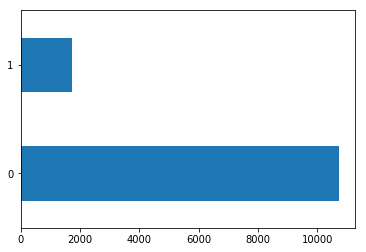

In [277]:
pd.Series(y_pred).value_counts().plot(kind='barh')

## Submission

In [620]:
cID=test_dataset_wo['id']
# drop ID column from test dataset
testing_values=test_dataset_wo.drop(['id'],axis=1)
# predictiction on given test
predict_test=cv_grid.predict(testing_values)
predictions = pd.DataFrame({'ID':cID,'Claim':predict_test})

print(predictions.Claim.value_counts(),np.bincount(y_pred))
predictions.to_csv("D:\Grayatom\input\submission.csv", index=False)

0    19930
1     2491
Name: Claim, dtype: int64 [10683  1807]


In [506]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# # create the sub models
estimators = []
model1 = LogisticRegression()
#estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
#estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
model4 = RandomForestClassifier()
#estimators.append(('RFC', model4))
model5 = GradientBoostingClassifier()
#estimators.append(('GBC', model5))
model6 = XGBClassifier()
#estimators.append(('XGB', model6))

# # create the ensemble model
ensemble = VotingClassifier(estimators)
#results = model_selection.cross_val_score(ensemble, X_train, y_train, cv=kfold)
#print(results.mean())
print("================================================================")
#results_samples = model_selection.cross_val_score(ensemble, x_train_res, y_train_res, cv=kfold)
#print(results_samples.mean())

In [584]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.007):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [585]:
X = train_dataset_wo.drop(['claim'], axis=1)
ct = ChiSquare(train_dataset_wo)

for c in X.columns:
    ct.TestIndependence(c, 'claim')
#train_dataset_wo.describe()

agency is IMPORTANT for Prediction
agency_type is IMPORTANT for Prediction
distribution_channel is NOT an important predictor. (Discard distribution_channel from model)
product_name is IMPORTANT for Prediction
duration is IMPORTANT for Prediction
destination is IMPORTANT for Prediction
net_sales is IMPORTANT for Prediction
commision_in_value is IMPORTANT for Prediction
age is IMPORTANT for Prediction
